# Learning to Drive in Adverse Weather Conditions

In [28]:
torch.cuda.empty_cache()

## Introduction & Setup

This project is designed to explore using Reinforcement learning to teach an autonomous agent to drive in adverse weather conditions.

### Setup

- The project will be performed using an autonomous drving simulator called CARLA.
- Python 3.8
- Anconda

[Project Github](https://github.com/rbuckley25/Tempestas)

### Image Segmentor

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import carla

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, Subset 
from torch.utils.data import ConcatDataset
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.utils import save_image
from models import PerceptionNet
from utils import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, weather, town, test=False , transform=None, target_transform=None):
        dirt = './Datasets/'+weather+'/'+town
        if test:
            dirt = dirt+'/test'
        
        self.sem_dir = dirt+'/Semantic'
        self.rgb_dir = dirt+'/RGB'
        self.transform = transform
        self.target_transform = target_transform
        self.names = os.listdir(self.rgb_dir)

    def __len__(self):
        return len(os.listdir(self.sem_dir))

    def __getitem__(self, idx): 
        img_path = os.path.join(self.rgb_dir, self.names[idx])
        image = read_image(img_path)
        label_name = self.names[idx].split('.')[0]+'.npy'
        label = np.load(os.path.join(self.sem_dir, label_name))
        label = torch.tensor(label).permute(2,0,1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
class CropResizeTransform:
    def __init__(self, top, left, width, height, size):
        self.top = top
        self.left = left
        self.width = width
        self.height = height
        self.size = size

    def __call__(self, x):
        return TF.resized_crop(x,self.top,self.left,self.width,self.height,self.size)

class Hflip:
    def __init__(self):
        pass

    def __call__(self, x):
        return TF.hflip(x)


In [4]:
class VAEPerceptionNet(nn.Module):

    def __init__(self):
        super(VAEPerceptionNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6a = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        self.conv6b = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        
        self.conv7 = torch.nn.ConvTranspose2d(64,512, kernel_size =4, stride=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.conv8 = torch.nn.ConvTranspose2d(512,256, kernel_size =4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv9 = torch.nn.ConvTranspose2d(256,128, kernel_size =4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.conv10 = torch.nn.ConvTranspose2d(128,64, kernel_size =4, stride=2, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv11 = torch.nn.ConvTranspose2d(64,32, kernel_size =4, stride=2, padding=1)
        self.bn10 = nn.BatchNorm2d(32)
        
        self.conv12 = torch.nn.ConvTranspose2d(32,13, kernel_size =4, stride=2,padding=1)
        
            
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x),negative_slope=0.02)
        x = F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.02)
        return self.conv6a(x), self.conv6b(x)

    
    def decode(self, x):
        x = F.leaky_relu(self.bn6(self.conv7(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn7(self.conv8(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn8(self.conv9(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn9(self.conv10(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn10(self.conv11(x)),negative_slope=0.02)
        return torch.sigmoid(self.conv12(x))

    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        latent_sample = mu + eps*std
        return latent_sample
    
    def forward(self, x):
        x = x.to(device, dtype=torch.float32)
        mu,logvar = self.encode(x)
        latent = self.reparameterize(mu,logvar)
        out = self.decode(latent)
        return out, latent, mu, logvar

In [8]:
model = PerceptionNet(device)
model.to(device)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [43]:
def initalize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer,torch.nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight.data,nonlinearity='relu')

In [58]:
model.apply(initalize_weights)

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss(weight=lable_weights)

In [76]:
def loss_fn(y_batch,pred,mu,logvar):
    cross = nn.CrossEntropyLoss(weight=lable_weights)
    rec_loss = cross(y_batch,pred)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec_loss + KLD

Reference: https://github.com/pytorch/examples/blob/master/vae/main.py

In [9]:
crop = CropResizeTransform(64,14,50,100,(128,128))
town03_data = CustomImageDataset('ClearNoon','Town03',test=False)
town03_test_data = CustomImageDataset('ClearNoon','Town03',test=True)
town04_data = CustomImageDataset('ClearNoon','Town04',test=False)
town04_test_data = CustomImageDataset('ClearNoon','Town04',test=True)
town07_data = CustomImageDataset('ClearNoon','Town07',test=False)
#flipped data
town03_data_hf = CustomImageDataset('ClearNoon','Town03',test=False,transform=Hflip(),target_transform=Hflip())
town03_test_data_hf = CustomImageDataset('ClearNoon','Town03',test=True,transform=Hflip(),target_transform=Hflip())
town04_data_hf = CustomImageDataset('ClearNoon','Town04',test=False,transform=Hflip(),target_transform=Hflip())
town04_test_data_hf = CustomImageDataset('ClearNoon','Town04',test=True,transform=Hflip(),target_transform=Hflip())
town07_data_hf = CustomImageDataset('ClearNoon','Town07',test=False,transform=Hflip(),target_transform=Hflip())

#town03_data_cropped = CustomImageDataset('Town03','.',test=False,transform=crop,target_transform=crop)
#town03_test_data_cropped = CustomImageDataset('Town03','.',test=True,transform=crop,target_transform=crop)
#town04_data_cropped = CustomImageDataset('Town04','.',test=False,transform=crop,target_transform=crop)
#town04_test_data_cropped = CustomImageDataset('Town04','.',test=True,transform=crop,target_transform=crop)



train_data = ConcatDataset([town03_data,town04_data,town07_data,town03_data_hf,town04_data_hf,town07_data_hf,
                            ])
#town03_data_cropped, town04_data_cropped
test_data = ConcatDataset([town03_test_data,town04_test_data,town03_test_data_hf,town04_test_data_hf,
                            ])
#town03_test_data_cropped, town04_test_data_cropped
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

In [10]:
train_data.__len__()

70488

In [ ]:
#generate label frequency for loss weigthing
label_freq_weights = np.zeros(13)
count = 0
for index, image in enumerate(train_data):
    if index % 100 == 0:
        im = recode_tags(image[1],recode_dict)
        values, counts = np.unique(im,return_counts=True)
        label_freq_weights[values] += counts

In [29]:
label_freq_weights_4 = np.array([1121034.,  530218.,  116395.,  193273.,   23201.,   83135.,
        258966., 6886841.,  121457.,  777388.,   23087.,  230427.,
         71186.])

In [16]:
label_freq_weights_4/40000

array([ 28.02585 ,  13.25545 ,   2.909875,   4.831825,   0.580025,
         2.078375,   6.47415 , 172.171025,   3.036425,  19.4347  ,
         0.577175,   5.760675,   1.77965 ])

In [9]:
label_freq_weights_3 = np.array([ 426548.,  103471.,   59734.,   61954.,    3507.,   17818.,
         40000., 2355300.,   28709.,  355806.,    4624.,   49085.,
         21033.])

In [ ]:
67739

In [ ]:
label_freq_weights_2 = np.array([2198123.,  321519.,   74114.,  139571.,    9590.,   49337.,
         94720., 1339440.,   78098.,  407971., 1242280.,  132659.,
         40194.])

In [ ]:
#need to caculate an individual weight for each sample for BCELoss
def calculate_weights(im_batch):
    weights = torch.empty(13)
    counts = torch.bincount(im_batch[i].reshape(128*128),minlength=13).numpy()
    counts = np.where(counts < 136.,  765703., 4474860.,  176931.,
         46304.])

In [10]:
clean_lables = np.where(label_freq_weights_3 < 10000, 15000, label_freq_weights_3)

inverse_lables = 1/clean_lables
normalized_lables = inverse_lables/sum(inverse_lables)
lable_weights = torch.tensor(normalized_lables,dtype=torch.float32).to(device)

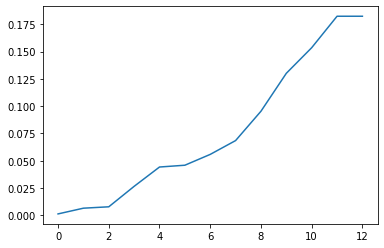

In [8]:
plt.plot(np.sort(normalized_lables))

In [ ]:
#need to caculate an individual weight for each sample for BCELoss
def calculate_weights(im_batch):
    weights = torch.empty(13)
    counts = torch.bincount(im_batch[i].reshape(128*128),minlength=13).numpy()
    counts = np.where(counts < 1, 1, counts)
    weights = torch.tensor((1/counts)/sum(1/counts))
    return weights


In [59]:
def train(epoch,recode_dict,writer):
    global step
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        rgb = data[0]
        target = data[1]
        target = recode_tags(target,recode_dict)
        batch_size = target.shape[0]
        #preds = F.one_hot(preds.to(torch.int64))
        target = target.reshape(batch_size,128,128)
        target = target.to(device,dtype=torch.long)
        optimizer.zero_grad()
        #dont need latent space output while training
        y_batch,_  = model(rgb)
        loss = loss_fn(y_batch,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_size * batch_idx, len(train_loader.dataset),
            100. * batch_idx / len(train_loader),
            loss.item() / len(data)))

        print(((epoch-1)*10)+step)
        writer.add_scalar("AE Loss", loss.item(), step)
        step += 1

    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.8f}'.format(
          epoch, avg_loss))
    writer.flush()
    return avg_loss
    
    


def test(epoch,recode_dict,writer):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            rgb = data[0]
            target = data[1]
            batch_size = target.shape[0]
            target = recode_tags(target,recode_dict)
            #preds = F.one_hot(preds.to(torch.int64))
            target = target.permute(0,3,1,2)
            target= target.reshape(batch_size,128,128)
            target = target.to(device,dtype=torch.long)
            y_batch,_   = model(rgb)
            test_loss += loss_fn(y_batch,target).item()

    print('====> Test set loss: {:.8f}'.format(test_loss))
    writer.add_scalar("AE test Loss", test_loss,epoch)
    writer.flush()

writer = SummaryWriter()
step = 0
for epoch in range(1, 20 + 1):
    
    smallest_loss = 1000
    
    avg_loss = train(epoch,recode_dict,writer)
    if avg_loss < smallest_loss:
        torch.save(model.state_dict(), './AE_params/model_54.best')
    test(epoch,recode_dict,writer)
    torch.save(model.state_dict(), './AE_params/model_54.final')
   

Train Epoch: 1 [0/70488 (0%)]	Loss: 1.304208
0
Train Epoch: 1 [512/70488 (1%)]	Loss: 1.301491
1
Train Epoch: 1 [1024/70488 (1%)]	Loss: 1.297177
2
Train Epoch: 1 [1536/70488 (2%)]	Loss: 1.291199
3
Train Epoch: 1 [2048/70488 (3%)]	Loss: 1.285601
4
Train Epoch: 1 [2560/70488 (4%)]	Loss: 1.282356
5
Train Epoch: 1 [3072/70488 (4%)]	Loss: 1.278005
6
Train Epoch: 1 [3584/70488 (5%)]	Loss: 1.275161
7
Train Epoch: 1 [4096/70488 (6%)]	Loss: 1.270067
8
Train Epoch: 1 [4608/70488 (7%)]	Loss: 1.264881
9
Train Epoch: 1 [5120/70488 (7%)]	Loss: 1.261491
10
Train Epoch: 1 [5632/70488 (8%)]	Loss: 1.255329
11
Train Epoch: 1 [6144/70488 (9%)]	Loss: 1.248807
12
Train Epoch: 1 [6656/70488 (9%)]	Loss: 1.246168
13
Train Epoch: 1 [7168/70488 (10%)]	Loss: 1.238505
14
Train Epoch: 1 [7680/70488 (11%)]	Loss: 1.231486
15
Train Epoch: 1 [8192/70488 (12%)]	Loss: 1.223813
16
Train Epoch: 1 [8704/70488 (12%)]	Loss: 1.219899
17
Train Epoch: 1 [9216/70488 (13%)]	Loss: 1.216299
18
Train Epoch: 1 [9728/70488 (14%)]	Loss: 

In [52]:
epoch=1

In [54]:
print(step)

63


In [13]:
recode_dict = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9,
    10:10,
    11:11,
    12:12,
    13:0,
    14:3,
    15:1,
    16:3,
    17:2,
    18:5,
    19:3,
    20:4,
    21:3,
    22:9,
}

In [14]:
def recode_tags(sem_image,recode_dict):
    for value in recode_dict.keys():
        sem_image[sem_image==value] = recode_dict[value]
    
    return sem_image

In [11]:
model.load_state_dict(torch.load('./AE_params/model_53.best'))
model.eval()

PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [226]:
old_data = town03_data = CustomImageDataset('.','Town03',test=False)
old_data.__len__()

17371

In [52]:

def get_iou_acc(pred,true):
    default_evaluator = create_supervised_evaluator(model)
    cm = ConfusionMatrix(num_classes=13)
    metric = IoU(cm)
    metric.attach(default_evaluator, 'iou')
    state = default_evaluator.run([[pred, true]])
    print(state.metrics['iou'])


52266


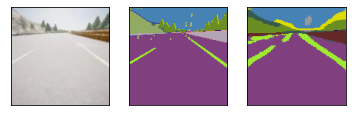

In [13]:
num = random.randint(1,70000)
print(num)
data = train_data.__getitem__(num)
imgs = []
org = data[0]
sem = replace(data[1].numpy().transpose(1,2,0))
imgs.append(Image.fromarray(org.numpy().transpose(1,2,0)))
imgs.append(Image.fromarray(sem))
imgs.append(generate_semantic_im(data[0],model))
fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
for i, img in enumerate(imgs):
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    #img.save('./AE_results/AE/'+str(num)+'_'+str(i)+'.png')



In [57]:
from ignite.engine import create_supervised_evaluator
from ignite.metrics import IoU, ConfusionMatrix

new_obs = data[0].reshape(1,3,128,128)


get_iou_acc(new_obs,data[0])




Current run is terminating due to exception: 'tuple' object has no attribute 'detach'
Engine run is terminating due to exception: 'tuple' object has no attribute 'detach'


AttributeError: 'tuple' object has no attribute 'detach'

In [20]:
get_iou_acc(generate_semantic_im(data[0],model),data[0])

NameError: name 'default_evaluator' is not defined

In [108]:
tag_convert_dict = {0:[70,130,180],
                   1:[70,70,70],
                   2:[100,40,40],
                   3:[55,90,80],
                   4:[220,20,60],
                   5:[153,153,153],
                   6:[157,234,50],
                   7:[128,64,128],
                   8:[244,35,232],
                   9:[107,142,35],
                   10:[0,0,142],
                   11:[102,102,156],
                   12:[220,220,0],
                   13:[70,130,180],
                   14:[81,0,81],
                   15:[150,100,100],
                   16:[230,150,140],
                   17:[180,165,180],
                   18:[250,170,30],
                   19:[110,190,160],
                   20:[170,120,50],
                   21:[45,60,150],
                   22:[145,170,100],
                  }

In [26]:
def generate_semantic_im(RGB_image):
    new_obs = RGB_image.reshape(1,3,128,128)
    out,_ ,_,_ = model(new_obs)
    sample = out.cpu().argmax(dim=1)
    print(sample.shape)
    pic = replace(sample.numpy())
    return Image.fromarray(pic,'RGB')

In [27]:
def replace(a):
    a = a.reshape(128,128)
    pic = np.zeros((128,128,3),dtype='uint8')
    for x, y in np.ndindex(a.shape):
        value = a[x,y]
        RGB_values = tag_convert_dict[value]
        pic[x,y,0] = RGB_values[0]
        pic[x,y,1] = RGB_values[1]
        pic[x,y,2] = RGB_values[2]
    return pic

In [ ]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
    num = random.randint(0,6000)
    data = town03_data.__getitem__(num)
    imgs = []
    org = data[0]
    org = TF.resized_crop(org,64,14,50,100,(128,128))
    sem = TF.resized_crop(torch.tensor(data[1]).permute(2,0,1),64,14,50,100,(128,128))
    
    sem = replace(data[1])


    imgs.append(Image.fromarray(org.numpy().transpose(1,2,0)))
    imgs.append(Image.fromarray(sem.reshape(128,128,3)))
    imgs.append(generate_semantic_im(org))
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])